In [2]:
from pathlib import Path

# Project root (one level above notebooks/)
PROJECT_ROOT = Path("..").resolve()

DATA_DIR = PROJECT_ROOT / "data"
OUTPUT_DIR = PROJECT_ROOT / "outputs"
SHAPEFILE_DIR = DATA_DIR / "shapefile"

print("Project root:", PROJECT_ROOT)


Project root: D:\MSc. Data Science\SEM - 4\UDAI HACKATHON\UIDAI_Operational_Stress


In [3]:
import pandas as pd
import glob

enrol_files = glob.glob("api_data_aadhar_enrolment_*.csv")

enrol_dfs = []
for f in enrol_files:
    enrol_dfs.append(pd.read_csv(f))

enrolment_full = pd.concat(enrol_dfs, ignore_index=True)

print("Enrolment rows:", enrolment_full.shape)
print("Date range:", enrolment_full["date"].min(), enrolment_full["date"].max())


ValueError: No objects to concatenate

In [ ]:
demo_files = glob.glob("api_data_aadhar_demographic_*.csv")

demo_dfs = []
for f in demo_files:
    demo_dfs.append(pd.read_csv(f))

demographic_full = pd.concat(demo_dfs, ignore_index=True)

print("Demographic rows:", demographic_full.shape)
print("Date range:", demographic_full["date"].min(), demographic_full["date"].max())


Demographic rows: (2071700, 6)
Date range: 01-03-2025 31-10-2025


In [ ]:
bio_files = glob.glob("api_data_aadhar_biometric_*.csv")

bio_dfs = []
for f in bio_files:
    bio_dfs.append(pd.read_csv(f))

biometric_full = pd.concat(bio_dfs, ignore_index=True)

print("Biometric rows:", biometric_full.shape)
print("Date range:", biometric_full["date"].min(), biometric_full["date"].max())


Biometric rows: (1861108, 6)
Date range: 01-03-2025 31-10-2025


In [ ]:
START_DATE = "2025-04-01"
END_DATE   = "2025-10-31"

start = pd.to_datetime(START_DATE)
end   = pd.to_datetime(END_DATE)

for df in [enrolment_full, demographic_full, biometric_full]:
    df["date"] = pd.to_datetime(df["date"], errors="coerce")

enrol_time = enrolment_full[(enrolment_full["date"] >= start) & (enrolment_full["date"] <= end)]
demo_time  = demographic_full[(demographic_full["date"] >= start) & (demographic_full["date"] <= end)]
bio_time   = biometric_full[(biometric_full["date"] >= start) & (biometric_full["date"] <= end)]

print("Rows after time filtering:")
print("Enrolment:", enrol_time.shape[0])
print("Demographic:", demo_time.shape[0])
print("Biometric:", bio_time.shape[0])


Rows after time filtering:
Enrolment: 176653
Demographic: 491165
Biometric: 454748


In [ ]:
def daily_total(df):
    age_cols = [c for c in df.columns if "age" in c.lower()]
    
    daily = (
        df
        .groupby("date")[age_cols]
        .sum()
        .sum(axis=1)
        .reset_index(name="total_activity")
    )
    return daily


enrol_daily = daily_total(enrol_time)
demo_daily  = daily_total(demo_time)
bio_daily   = daily_total(bio_time)

print("Enrolment daily sample:")
print(enrol_daily.head())

print("\nDemographic daily sample:")
print(demo_daily.head())

print("\nBiometric daily sample:")
print(bio_daily.head())


Enrolment daily sample:
        date  total_activity
0 2025-04-09           65349
1 2025-04-11            1007
2 2025-05-09           26069
3 2025-05-11           75593
4 2025-06-09           58957

Demographic daily sample:
        date  total_activity
0 2025-04-09          383726
1 2025-04-11          529318
2 2025-04-12          477502
3 2025-05-09          273954
4 2025-05-11          259691

Biometric daily sample:
        date  total_activity
0 2025-04-09          301023
1 2025-04-11          288485
2 2025-04-12          449873
3 2025-05-09           95781
4 2025-05-11          356460


In [ ]:
print("Enrolment days:", enrol_daily.shape[0])
print("Demographic days:", demo_daily.shape[0])
print("Biometric days:", bio_daily.shape[0])

print("\nDate ranges:")
print(enrol_daily["date"].min(), "to", enrol_daily["date"].max())
print(demo_daily["date"].min(), "to", demo_daily["date"].max())
print(bio_daily["date"].min(), "to", bio_daily["date"].max())


Enrolment days: 15
Demographic days: 21
Biometric days: 21

Date ranges:
2025-04-09 00:00:00 to 2025-10-11 00:00:00
2025-04-09 00:00:00 to 2025-10-12 00:00:00
2025-04-09 00:00:00 to 2025-10-12 00:00:00


In [ ]:
all_days = pd.date_range(start="2025-04-01", end="2025-10-31")

missing_enrol = set(all_days) - set(enrol_daily["date"])
missing_demo  = set(all_days) - set(demo_daily["date"])
missing_bio   = set(all_days) - set(bio_daily["date"])

print("Missing enrolment days:", len(missing_enrol))
print("Missing demographic days:", len(missing_demo))
print("Missing biometric days:", len(missing_bio))


Missing enrolment days: 199
Missing demographic days: 193
Missing biometric days: 193


In [ ]:
# rename columns to avoid confusion
enrol_daily = enrol_daily.rename(columns={"total_activity": "enrolment_total"})
demo_daily  = demo_daily.rename(columns={"total_activity": "demographic_total"})
bio_daily   = bio_daily.rename(columns={"total_activity": "biometric_total"})

# merge on date (inner join = common reporting days)
time_compare = (
    enrol_daily
    .merge(demo_daily, on="date", how="inner")
    .merge(bio_daily, on="date", how="inner")
)

print("Common reporting days:", time_compare.shape[0])
print(time_compare.head())


Common reporting days: 14
        date  enrolment_total  demographic_total  biometric_total
0 2025-04-09            65349             383726           301023
1 2025-04-11             1007             529318           288485
2 2025-05-09            26069             273954            95781
3 2025-05-11            75593             259691           356460
4 2025-06-09            58957             368240           254489


In [ ]:
time_compare["demo_to_enrol_ratio"] = (
    time_compare["demographic_total"] / time_compare["enrolment_total"]
)

time_compare["bio_to_enrol_ratio"] = (
    time_compare["biometric_total"] / time_compare["enrolment_total"]
)

time_compare["bio_to_demo_ratio"] = (
    time_compare["biometric_total"] / time_compare["demographic_total"]
)

print(time_compare[[
    "date",
    "demo_to_enrol_ratio",
    "bio_to_enrol_ratio",
    "bio_to_demo_ratio"
]])


         date  demo_to_enrol_ratio  bio_to_enrol_ratio  bio_to_demo_ratio
0  2025-04-09             5.871949            4.606390           0.784474
1  2025-04-11           525.638530          286.479643           0.545013
2  2025-05-09            10.508804            3.674134           0.349624
3  2025-05-11             3.435384            4.715516           1.372631
4  2025-06-09             6.245908            4.316519           0.691095
5  2025-06-11            13.591350            9.611839           0.707203
6  2025-07-09             6.073885            2.248329           0.370163
7  2025-07-11            11.035554            8.761399           0.793925
8  2025-08-09             6.426067            4.987439           0.776126
9  2025-08-11             9.159188            6.835392           0.746288
10 2025-09-09             5.746644            4.667906           0.812284
11 2025-09-11             3.064891            4.811133           1.569756
12 2025-10-09             5.731471    

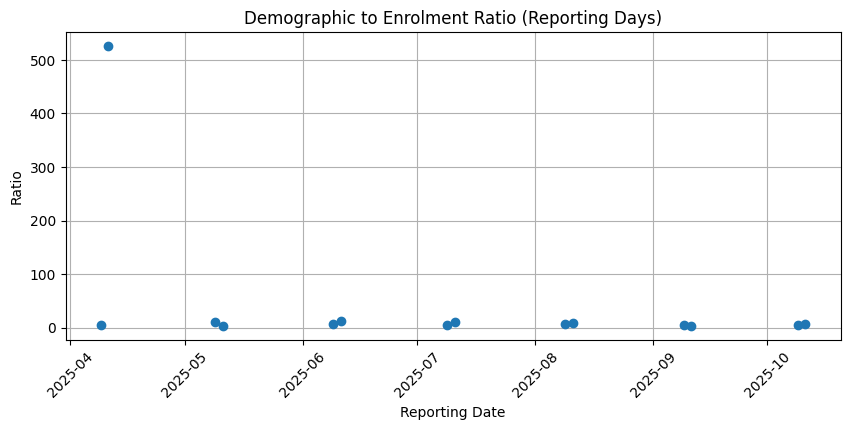

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(
    time_compare["date"],
    time_compare["demo_to_enrol_ratio"],
    marker="o",
    linestyle="None"
)
plt.title("Demographic to Enrolment Ratio (Reporting Days)")
plt.xlabel("Reporting Date")
plt.ylabel("Ratio")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


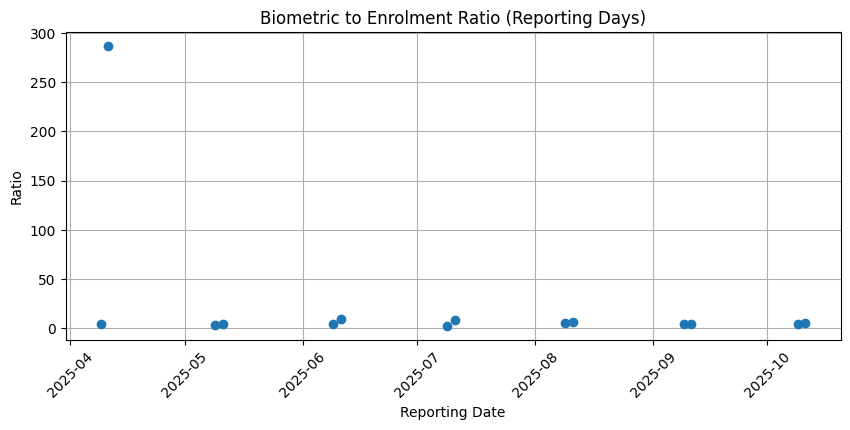

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(
    time_compare["date"],
    time_compare["bio_to_enrol_ratio"],
    marker="o",
    linestyle="None"
)
plt.title("Biometric to Enrolment Ratio (Reporting Days)")
plt.xlabel("Reporting Date")
plt.ylabel("Ratio")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


END OF TIMEBASED UNDERSTANDING